In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [8]:

input_df = pd.read_csv("data_in.csv")
output_df = pd.read_csv("data_out.csv")

X = input_df.values
y = output_df.values

assert X.shape[0] == y.shape[0] # The number of rows in input and output data must match
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

n_samples = X.shape[0]
n_train = int(n_samples * 0.8)
n_test = n_samples - n_train

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

# Checing sizes again
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X shape: (35039, 182)
y shape: (35039, 556)
X_train shape: (28031, 182)
X_test shape: (7008, 182)
y_train shape: (28031, 556)
y_test shape: (7008, 556)


In [9]:
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_train_normalized = (X_train - X_mean) / X_std
X_test_normalized = (X_test - X_mean) / X_std

y_mean = np.mean(y_train, axis=0)
y_std = np.std(y_train, axis=0)
y_train_normalized = (y_train - y_mean) / y_std
y_test_normalized = (y_test - y_mean) / y_std

In [10]:
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

Epoch [100/1000], Train Loss: 0.1884, Test Loss: 0.0781
Epoch [200/1000], Train Loss: 0.1776, Test Loss: 0.0604
Epoch [300/1000], Train Loss: 0.1755, Test Loss: 0.0605
Epoch [400/1000], Train Loss: 0.1769, Test Loss: 0.0601
Epoch [500/1000], Train Loss: 0.1765, Test Loss: 0.0605
Epoch [600/1000], Train Loss: 0.1756, Test Loss: 0.0602
Epoch [700/1000], Train Loss: 0.1768, Test Loss: 0.0601
Epoch [800/1000], Train Loss: 0.1765, Test Loss: 0.0601
Epoch [900/1000], Train Loss: 0.1778, Test Loss: 0.0599
Epoch [1000/1000], Train Loss: 0.1753, Test Loss: 0.0603


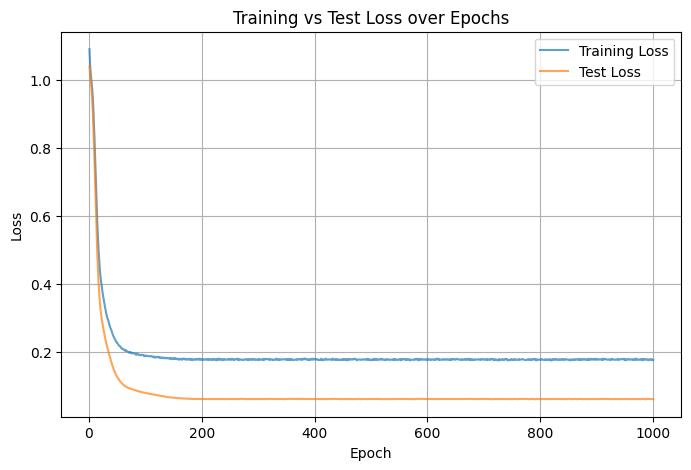

In [18]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize Model, Loss Function, and Optimizer
input_size = X_train_tensor.shape[1]
hidden_size = 18
output_size = y_train_tensor.shape[1]

Net = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr=0.01)  # Adjusted learning rate

# Training Function
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=1000):
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Evaluate on Test Data
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

# Train the Model
train_losses, test_losses = train_model(Net, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# Plot Training vs Test Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", alpha=0.7)
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Net.eval()
with torch.no_grad():
    test_predictions = Net(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Loss (MSE): {test_loss.item():.4f}')

    # Calculate Mean Absolute Error (MAE)
    test_mae = torch.mean(torch.abs(test_predictions - y_test_tensor))
    print(f'Test MAE: {test_mae.item():.4f}') 

    # Convert Tensor to NumPy
    test_predictions = test_predictions.cpu().numpy()  # Ensure conversion
    y_test_actual = y_test_tensor.cpu().numpy()  # Convert actual values

    # Undo Normalization
    test_predictions_denormalized = test_predictions * y_std + y_mean
    y_test_actual_denormalized = y_test_actual * y_std + y_mean

    # Print Shapes for Debugging
    print("Predictions Shape:", test_predictions_denormalized.shape)
    print("Actual Test Data Shape:", y_test_actual_denormalized.shape)


Test Loss (MSE): 0.0603
Test MAE: 0.1917
Predictions Shape: (7008, 556)
Actual Test Data Shape: (7008, 556)


Voltage RMSE: 0.0004
Phase RMSE: 0.0004


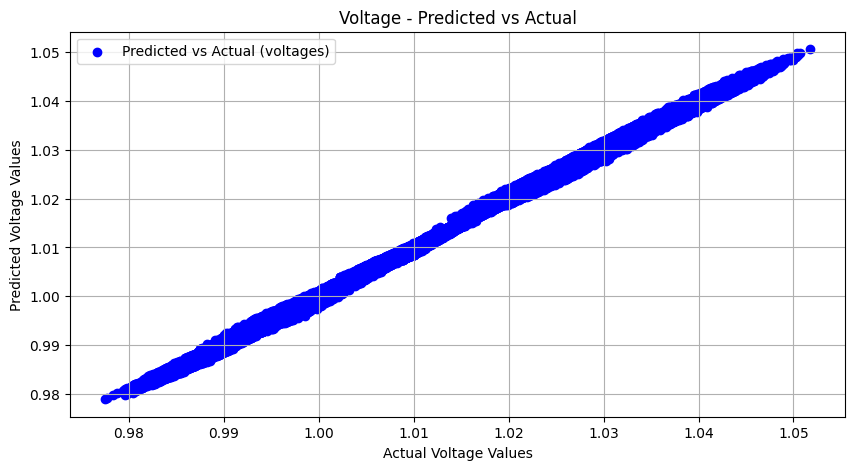

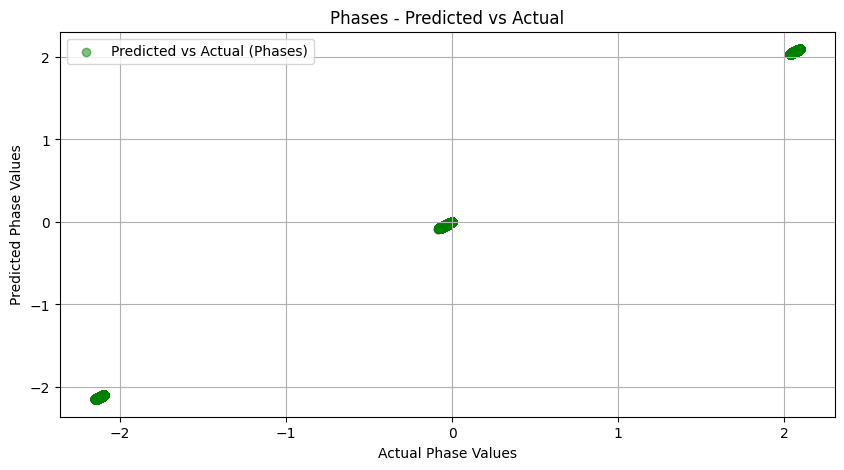

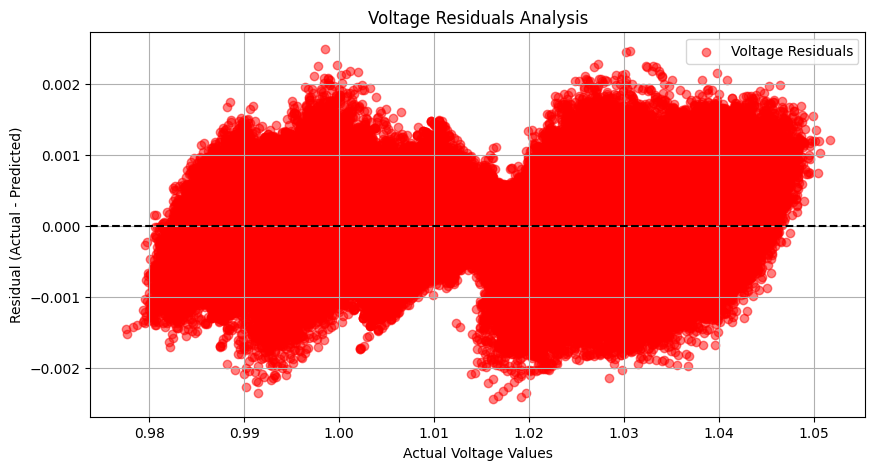

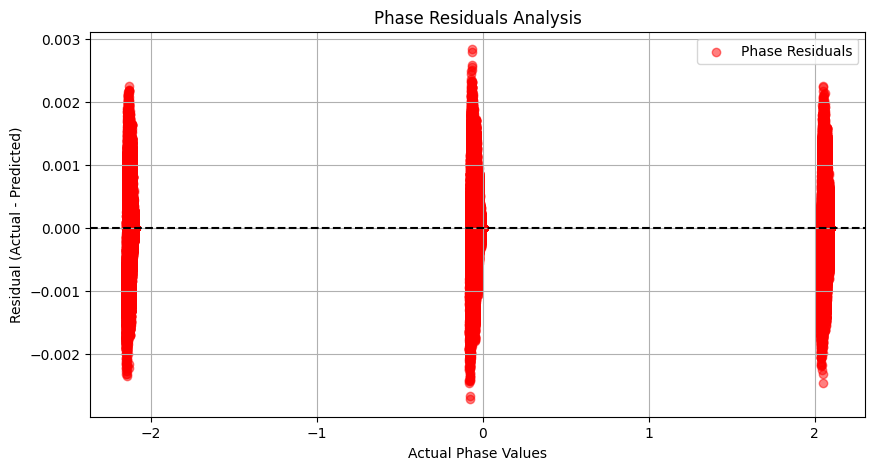

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Ensure Data is in NumPy Format
# Only convert if they are DataFrames
if isinstance(actual_test_denormalized, pd.DataFrame):
    actual_test_denormalized = actual_test_denormalized.to_numpy()
if isinstance(test_predictions_denormalized, pd.DataFrame):
    test_predictions_denormalized = test_predictions_denormalized.to_numpy()

# Extract Voltages & Phases
voltage_actual = actual_test_denormalized[:, :279]
voltage_predicted = test_predictions_denormalized[:, :279]

phases_actual = actual_test_denormalized[:, 279:]
phases_predicted = test_predictions_denormalized[:, 279:]


# Compute & Print RMSE
def compute_rmse(actual, predicted, label=""):
    """Compute RMSE and print results."""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()
    
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f'{label} RMSE: {rmse:.4f}')
    return rmse

voltage_rmse = compute_rmse(voltage_actual, voltage_predicted, label="Voltage")
phase_rmse = compute_rmse(phases_actual, phases_predicted, label="Phase")


# Scatter Plots (Original Voltages & Phases)
# Filter for voltages where actual values are greater than zero
voltage_mask = voltage_actual.flatten() > 0
voltage_actual_filtered = voltage_actual.flatten()[voltage_mask]
voltage_predicted_filtered = voltage_predicted.flatten()[voltage_mask]

plt.figure(figsize=(10, 5))
plt.scatter(voltage_actual_filtered, voltage_predicted_filtered, label='Predicted vs Actual (voltages)', color='blue')
plt.xlabel('Actual Voltage Values')
plt.ylabel('Predicted Voltage Values')
plt.title('Voltage - Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(phases_actual.flatten(), phases_predicted.flatten(), label='Predicted vs Actual (Phases)', color='green', alpha=0.5)
plt.xlabel('Actual Phase Values')
plt.ylabel('Predicted Phase Values')
plt.title('Phases - Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()


# Residual Analysis (Scatter Plot Only)

def plot_residuals(actual, predicted, label=""):
    """Plot residuals scatter plot."""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()
    
    residuals = actual - predicted
    plt.figure(figsize=(10, 5))
    plt.scatter(actual, residuals, label=f'{label} Residuals', color='red', alpha=0.5)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel(f'Actual {label} Values')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title(f'{label} Residuals Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return residuals

voltage_residuals = plot_residuals(voltage_actual_filtered, voltage_predicted_filtered, label="Voltage")
phase_residuals = plot_residuals(phases_actual, phases_predicted, label="Phase")


Phases Seperation

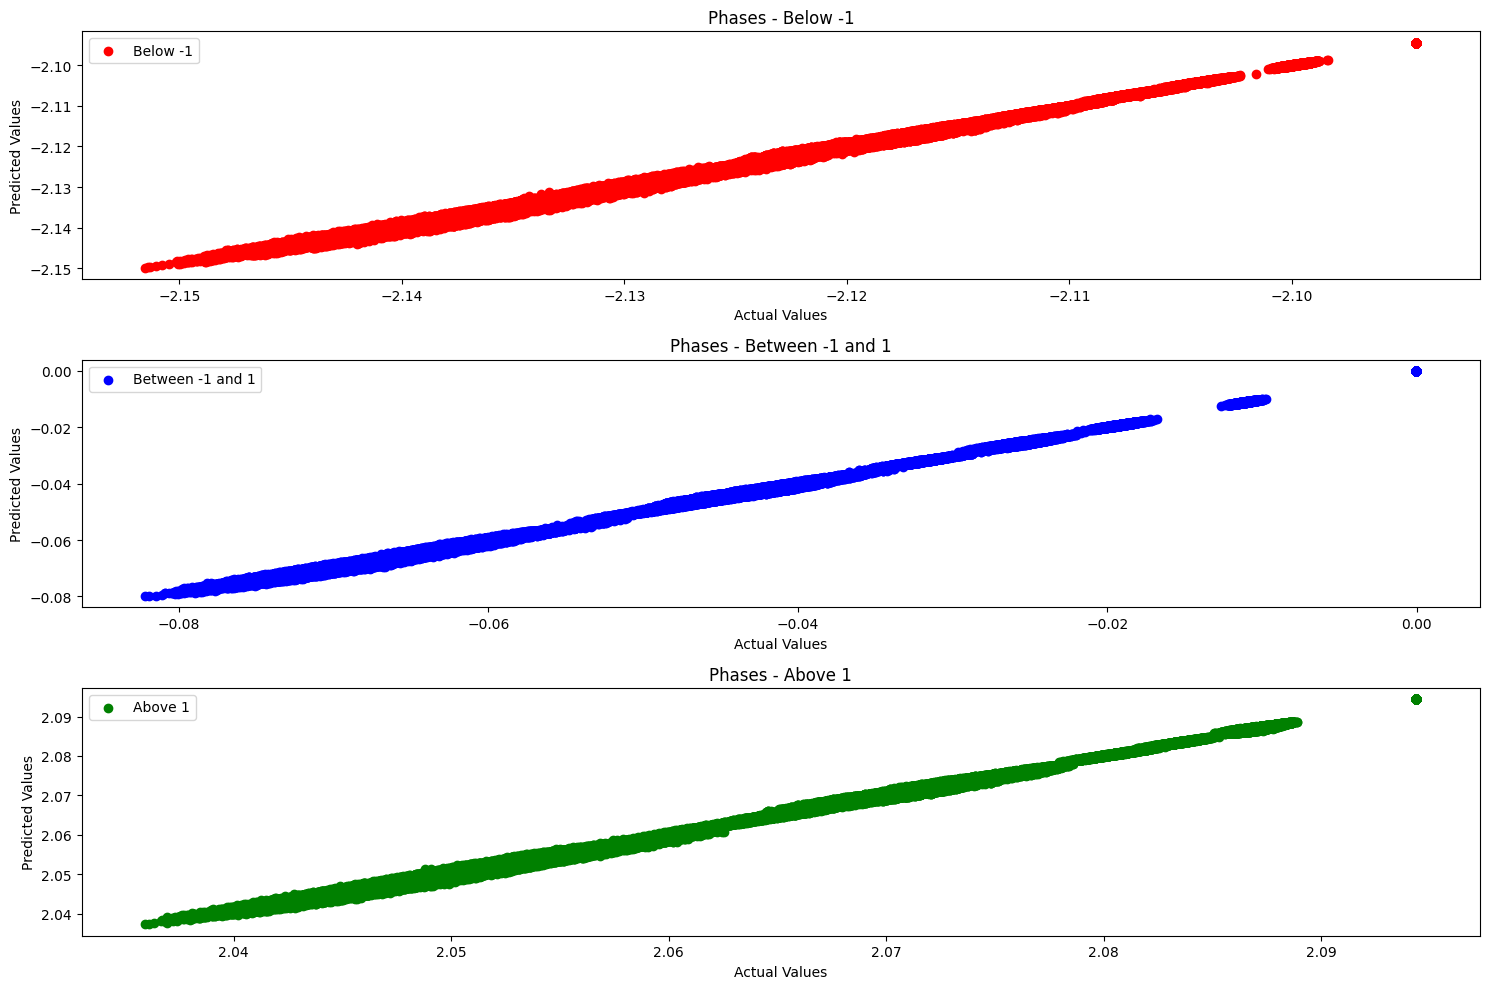

Below -1 RMSE: 0.0004
Between -1 and 1 RMSE: 0.0005
Above 1 RMSE: 0.0004


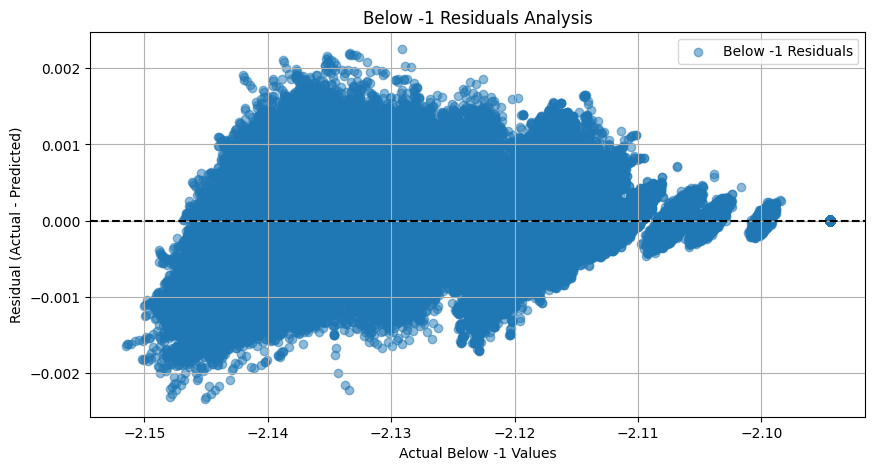

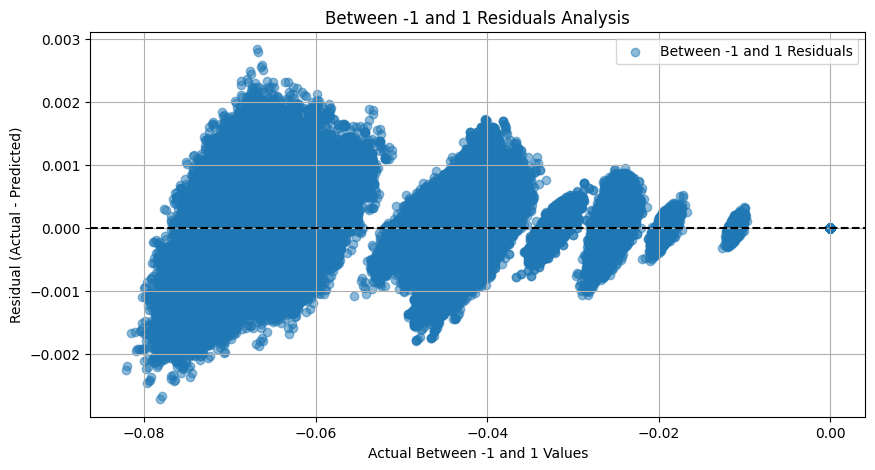

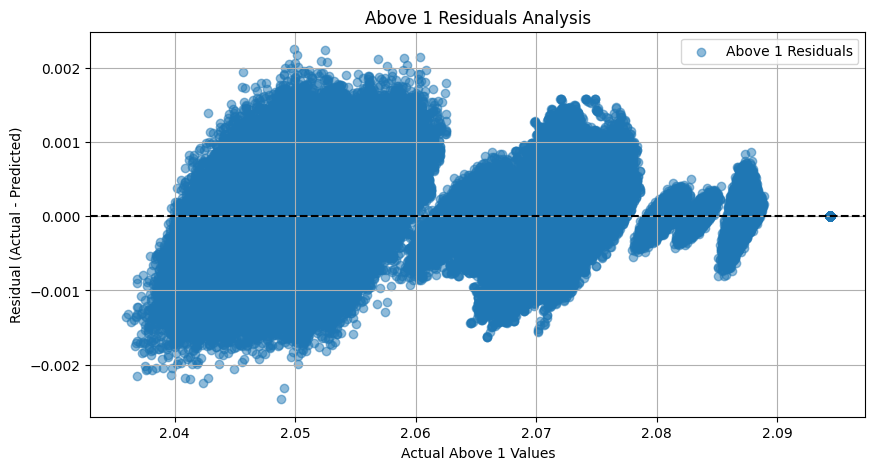

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Flatten the Arrays for Easier Handling

phases_actual_flat = phases_actual.flatten()
phases_predicted_flat = phases_predicted.flatten()

# Create masks for thresholds
below_negative_one_mask = phases_actual_flat < -1
between_neg1_and_1_mask = (phases_actual_flat >= -1) & (phases_actual_flat <= 1)
above_one_mask = phases_actual_flat > 1

# Categorize phases (Actual & Predicted)
below_negative_one_actual = phases_actual_flat[below_negative_one_mask]
below_negative_one_predicted = phases_predicted_flat[below_negative_one_mask]

between_neg1_and_1_actual = phases_actual_flat[between_neg1_and_1_mask]
between_neg1_and_1_predicted = phases_predicted_flat[between_neg1_and_1_mask]

above_one_actual = phases_actual_flat[above_one_mask]
above_one_predicted = phases_predicted_flat[above_one_mask]


# Original Scatter Plots (Keeping Your Code)

plt.figure(figsize=(15, 10))

# Below -1
plt.subplot(3, 1, 1)
plt.scatter(below_negative_one_actual, below_negative_one_predicted, color='red', label='Below -1')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Phases - Below -1')
plt.legend()

# Between -1 and 1
plt.subplot(3, 1, 2)
plt.scatter(between_neg1_and_1_actual, between_neg1_and_1_predicted, color='blue', label='Between -1 and 1')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Phases - Between -1 and 1')
plt.legend()

# Above 1
plt.subplot(3, 1, 3)
plt.scatter(above_one_actual, above_one_predicted, color='green', label='Above 1')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Phases - Above 1')
plt.legend()

plt.tight_layout()
plt.show()

# Compute RMSE for Each Phase Category

def compute_rmse(actual, predicted, label=""):
    """Compute RMSE for a specific phase category."""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f'{label} RMSE: {rmse:.4f}')
    return rmse

rmse_below_negative_one = compute_rmse(below_negative_one_actual, below_negative_one_predicted, label="Below -1")
rmse_between_neg1_and_1 = compute_rmse(between_neg1_and_1_actual, between_neg1_and_1_predicted, label="Between -1 and 1")
rmse_above_one = compute_rmse(above_one_actual, above_one_predicted, label="Above 1")


# Residual Analysis for Each Phase

def plot_residuals(actual, predicted, label=""):
    """Plot residuals (Actual - Predicted) for a specific phase category."""
    residuals = np.array(actual).flatten() - np.array(predicted).flatten()
    plt.figure(figsize=(10, 5))
    plt.scatter(actual, residuals, label=f'{label} Residuals', alpha=0.5)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel(f'Actual {label} Values')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title(f'{label} Residuals Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_residuals(below_negative_one_actual, below_negative_one_predicted, label="Below -1")
plot_residuals(between_neg1_and_1_actual, between_neg1_and_1_predicted, label="Between -1 and 1")
plot_residuals(above_one_actual, above_one_predicted, label="Above 1")



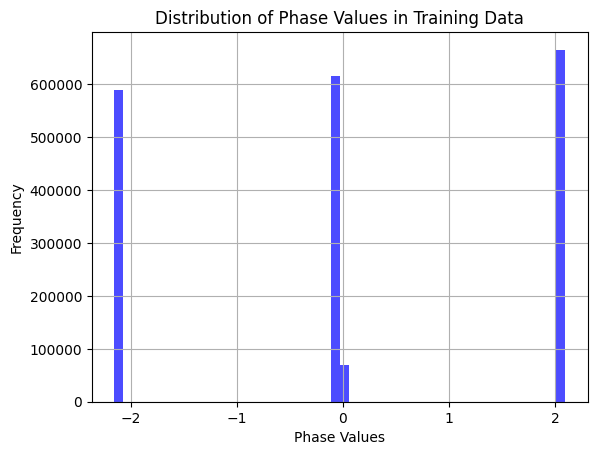

In [34]:
plt.hist(phases_actual.flatten(), bins=50, color="blue", alpha=0.7)
plt.xlabel("Phase Values")
plt.ylabel("Frequency")
plt.title("Distribution of Phase Values in Training Data")
plt.grid(True)
plt.show()


Voltages Separation

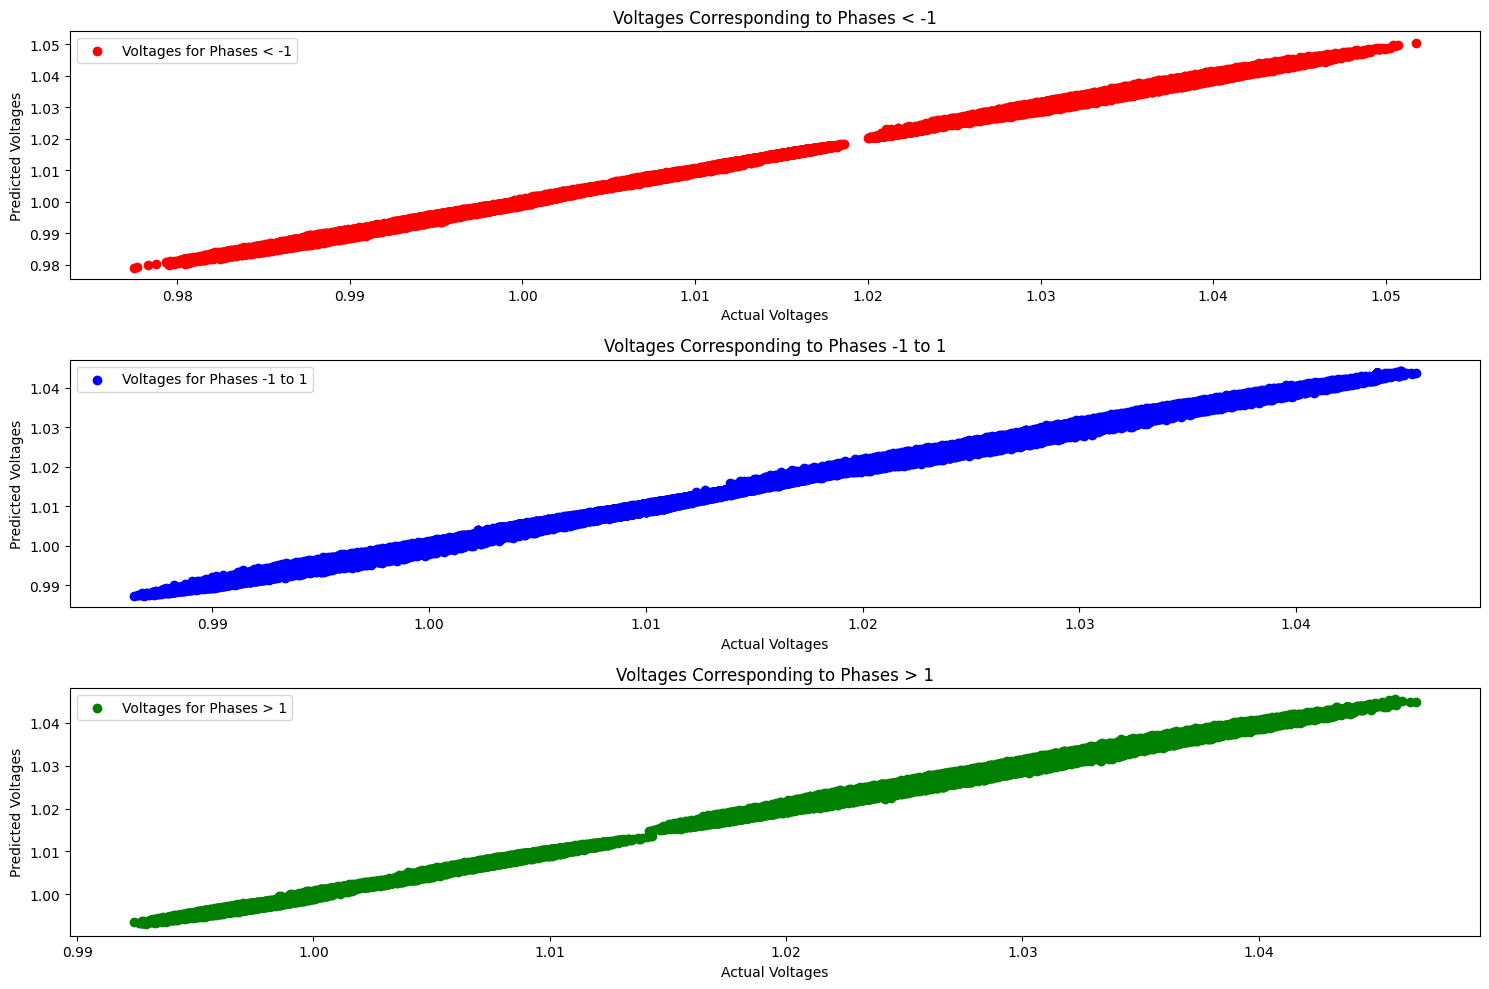

Voltages for Phases < -1 RMSE: 0.0004
Voltages for Phases -1 to 1 RMSE: 0.0004
Voltages for Phases > 1 RMSE: 0.0004


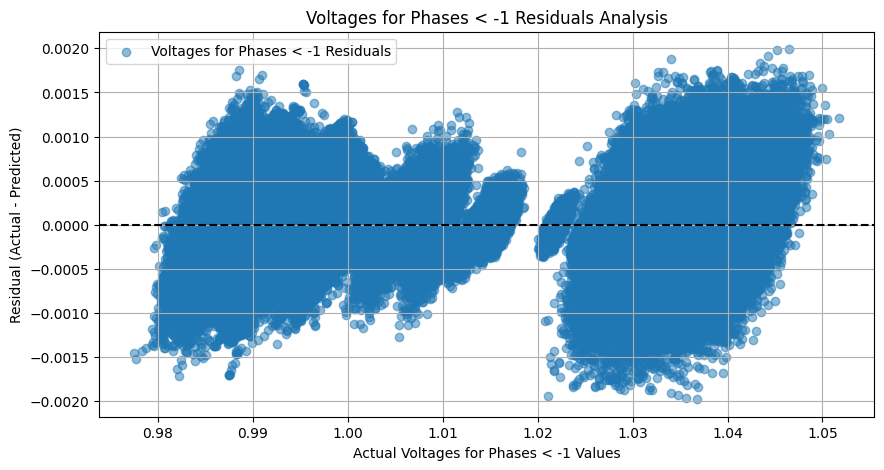

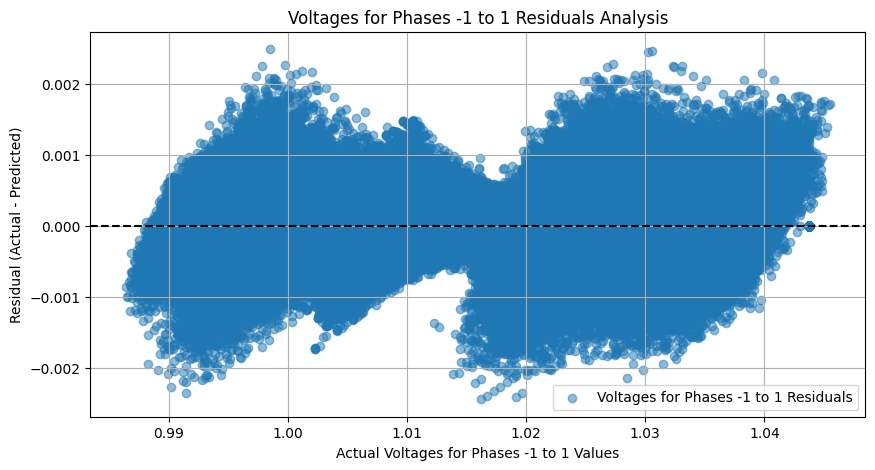

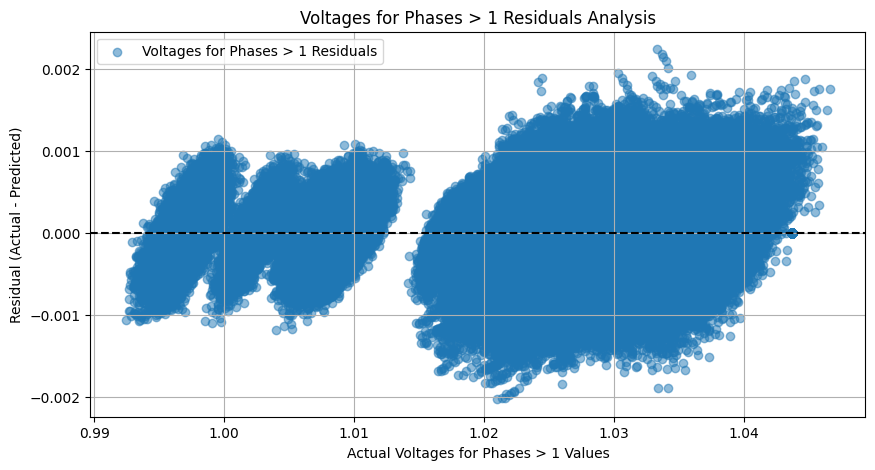

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Categorizing Voltages Based on Phases

below_negative_one_actual_voltages = []
below_negative_one_predicted_voltages = []

between_neg1_and_1_actual_voltages = []
between_neg1_and_1_predicted_voltages = []

above_one_actual_voltages = []
above_one_predicted_voltages = []

# Iterate row-by-row
for row_idx in range(phases_actual.shape[0]):
    # Extract rows
    phase_row = phases_actual[row_idx]
    voltage_actual_row = voltage_actual[row_idx]
    voltage_predicted_row = voltage_predicted[row_idx]

    # Ensure all arrays have the same length
    min_length = min(len(phase_row), len(voltage_actual_row), len(voltage_predicted_row))
    phase_row = phase_row[:min_length]
    voltage_actual_row = voltage_actual_row[:min_length]
    voltage_predicted_row = voltage_predicted_row[:min_length]

    # Create masks for phases
    below_negative_one_mask = phase_row < -1
    between_neg1_and_1_mask = (phase_row >= -1) & (phase_row <= 1)
    above_one_mask = phase_row > 1

    # Apply masks to voltages row-by-row
    below_negative_one_actual_voltages.extend(voltage_actual_row[below_negative_one_mask])
    below_negative_one_predicted_voltages.extend(voltage_predicted_row[below_negative_one_mask])

    between_neg1_and_1_actual_voltages.extend(voltage_actual_row[between_neg1_and_1_mask])
    between_neg1_and_1_predicted_voltages.extend(voltage_predicted_row[between_neg1_and_1_mask])

    above_one_actual_voltages.extend(voltage_actual_row[above_one_mask])
    above_one_predicted_voltages.extend(voltage_predicted_row[above_one_mask])

# Original Voltage Scatter Plots 

plt.figure(figsize=(15, 10))

# Voltages for Phases < -1
plt.subplot(3, 1, 1)
plt.scatter(below_negative_one_actual_voltages, below_negative_one_predicted_voltages, color='red', label='Voltages for Phases < -1')
plt.xlabel('Actual Voltages')
plt.ylabel('Predicted Voltages')
plt.title('Voltages Corresponding to Phases < -1')
plt.legend()

# Voltages for Phases -1 to 1
plt.subplot(3, 1, 2)
plt.scatter(between_neg1_and_1_actual_voltages, between_neg1_and_1_predicted_voltages, color='blue', label='Voltages for Phases -1 to 1')
plt.xlabel('Actual Voltages')
plt.ylabel('Predicted Voltages')
plt.title('Voltages Corresponding to Phases -1 to 1')
plt.legend()

# Voltages for Phases > 1
plt.subplot(3, 1, 3)
plt.scatter(above_one_actual_voltages, above_one_predicted_voltages, color='green', label='Voltages for Phases > 1')
plt.xlabel('Actual Voltages')
plt.ylabel('Predicted Voltages')
plt.title('Voltages Corresponding to Phases > 1')
plt.legend()

plt.tight_layout()
plt.show()


# Compute RMSE for Each Voltage-Phase Category

def compute_rmse(actual, predicted, label=""):
    """Compute RMSE for a specific voltage-phase category."""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f'{label} RMSE: {rmse:.4f}')
    return rmse

rmse_below_negative_one = compute_rmse(below_negative_one_actual_voltages, below_negative_one_predicted_voltages, label="Voltages for Phases < -1")
rmse_between_neg1_and_1 = compute_rmse(between_neg1_and_1_actual_voltages, between_neg1_and_1_predicted_voltages, label="Voltages for Phases -1 to 1")
rmse_above_one = compute_rmse(above_one_actual_voltages, above_one_predicted_voltages, label="Voltages for Phases > 1")


# Residual Analysis for Each Voltage-Phase Category

def plot_residuals(actual, predicted, label=""):
    """Plot residuals (Actual - Predicted) for a specific voltage-phase category."""
    residuals = np.array(actual).flatten() - np.array(predicted).flatten()
    plt.figure(figsize=(10, 5))
    plt.scatter(actual, residuals, label=f'{label} Residuals', alpha=0.5)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel(f'Actual {label} Values')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title(f'{label} Residuals Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_residuals(below_negative_one_actual_voltages, below_negative_one_predicted_voltages, label="Voltages for Phases < -1")
plot_residuals(between_neg1_and_1_actual_voltages, between_neg1_and_1_predicted_voltages, label="Voltages for Phases -1 to 1")
plot_residuals(above_one_actual_voltages, above_one_predicted_voltages, label="Voltages for Phases > 1")
